In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', None)
from apyori import apriori as ap_apyori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns.fpgrowth import fpgrowth
from mlxtend.frequent_patterns.apriori import  apriori
from mlxtend.frequent_patterns.fpmax import fpmax
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 7)

In [134]:
# function to plot data
def plot_res(data, left_desc_col = 'antecedents', right_desc_col='consequents', sort_col = 'lift'):
    plot_df = data.sort_values(by=sort_col, ascending=False).head(15)[[left_desc_col, right_desc_col, sort_col]]
    plot_df['rule'] = plot_df.apply(lambda x:str(x.loc[left_desc_col]) + ' --> ' + str(x.loc[right_desc_col]), axis=1)
    plot_df.drop(columns=[left_desc_col, right_desc_col], inplace=True)
    plot_df.sort_values(by=sort_col, inplace=True)
    plot_df.plot(kind='barh', y = sort_col, x='rule')
    plt.show()


# Association concerning only the products bought

In this section I consider the association rules concering the broducts bought by clients (groupped by the invoice), so possible connection between different categories of products bought together. I usually set min_support to 0.003 as it turned out to optimal value for this data to get satisfying number of frequent set/association rules. The min confidence I set accoriding to the data and used implelemtation. I usually show some number of best lift rules (e.g., top15)

## Data preparation

In [3]:
Data = pd.read_excel('./data/Online Retail.xlsx')
Data.StockCode = Data.StockCode.astype('string')
# gather descriptions of stock items
items_descriptions = Data[["StockCode", "Description"]].set_index('StockCode')
items_descriptions = items_descriptions[~items_descriptions.index.duplicated()]

In [4]:
Data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [5]:
# prepare transations - stock items groupped by the invoice
transactions = list(Data[["InvoiceNo", "StockCode"]].groupby(by="InvoiceNo").apply(lambda x: list(x["StockCode"])))

## Apriori

For investigating products association rules I use apyori library and mlxtend with fpgrowth and fpmax.

In [6]:
rule = ap_apyori(transactions=transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 50, min_length = 2, max_length = 2)

In [7]:
# putting output into a pandas dataframe (taken from classes tutorial)
def inspect(output):
        lhs         = [tuple(result[2][0][0])[0] for result in output]
        rhs         = [tuple(result[2][0][1])[0] for result in output]
        support    = [result[1] for result in output]
        confidence = [result[2][0][2] for result in output]
        lift       = [result[2][0][3] for result in output]
        return list(zip(lhs, rhs, support, confidence, lift))


def rule_to_df(rule):
    output = list(rule) # returns a non-tabular output
    results = output
    output_DataFrame = pd.DataFrame(inspect(results),columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
    output_DataFrame['Left_item_descr'] = items_descriptions.loc[output_DataFrame.Left_Hand_Side.values]['Description'].values
    output_DataFrame['Right_item_descr'] = items_descriptions.loc[output_DataFrame.Right_Hand_Side.values]['Description'].values
    return output_DataFrame

In [8]:
apriori_res = rule_to_df(rule)

In [65]:
# select rules with highest Lift values (top 3) - all information: confidence, support, lift, descriptions
apriori_res.sort_values(by="Lift", ascending=False).head(3)

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift,Left_item_descr,Right_item_descr
7,21088,21096,0.003127,0.778846,192.115385,SET/6 FRUIT SALAD PAPER CUPS,SET/6 FRUIT SALAD PAPER PLATES
206,23498,23552,0.003089,0.808081,180.424939,CLASSIC BICYCLE CLIPS,BICYCLE PUNCTURE REPAIR KIT
66,22520,22522,0.003243,0.717949,141.945586,CHILDS GARDEN TROWEL BLUE,CHILDS GARDEN FORK BLUE


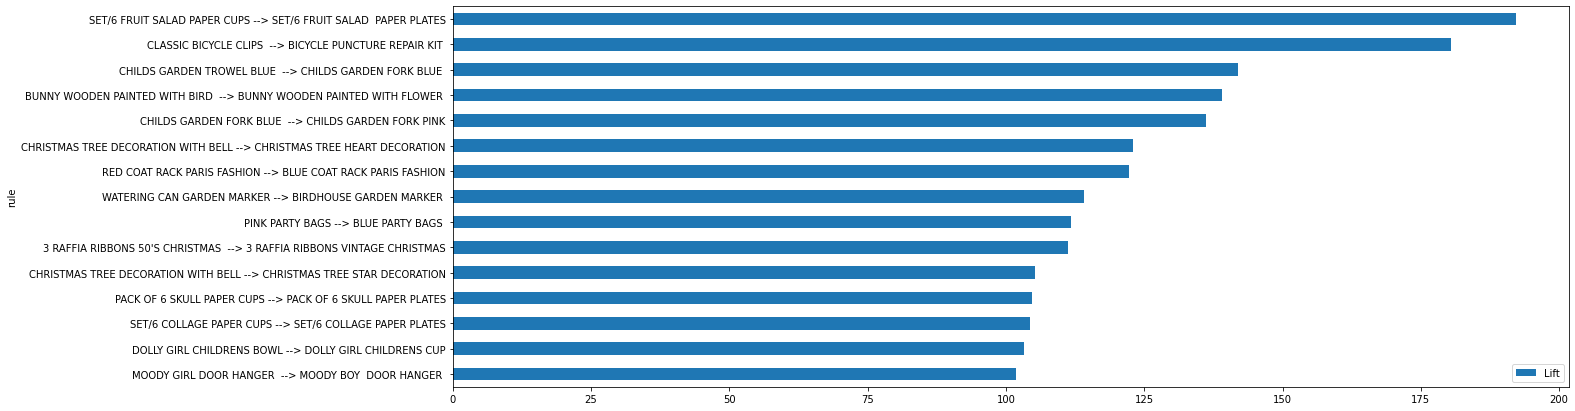

In [135]:
# visualize top 15
plot_res(data=apriori_res, left_desc_col='Left_item_descr', right_desc_col='Right_item_descr', sort_col='Lift')    

We can see that obtained rules are kind of expected. In fact, people who buy SET/6 FRUIT SALAD PAPER CUPS are usually willing to buy SET/6 FRUIT SALAD PAPER PLATES too, because these products are often used together (to eat outside for example). Also, some bicycle accesories (CLASSIC BICYCLE CLIPS, BICYCLE PUNCTURE REPAIR KIT) are expected to be bought together. When you buy MOODY GIRL DOOR HANGER for your daughter, you probably should also buy one (MOODY BOY DOOR HANGER) for you son, not to make him feel left out. And similarly for other association rules visible above. 

## FP Growth

In [32]:
# transform data since fpgrowth needs another format (binary table)
my_transactionencoder = TransactionEncoder()
my_transactionencoder.fit(transactions)
encoded_transactions = my_transactionencoder.transform(transactions)
encoded_transactions_df = pd.DataFrame(encoded_transactions, columns=my_transactionencoder.columns_)

In [33]:
# find frequent sets
min_support = 0.003
frequent_itemsets = fpgrowth(encoded_transactions_df, min_support=min_support, use_colnames = True).sort_values(by="support")

In [34]:
frequent_itemsets.head()

,support,itemsets
43820,0.003012,"(20724, 20719, 20723, 22725)"
42476,0.003012,"(22818, 22961)"
21957,0.003012,"(21494, 21935, 84032A, 22697)"
21958,0.003012,"(DOT, 84032A, 21935, 21494, 22697)"
21992,0.003012,"(21494, DOT, 21790, 21993)"


In [35]:
# find associatition rules
rules_fpgrowth = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.95).sort_values(by="lift", ascending=False)

In [36]:
# add descriptions of items found in itemsets
rules_fpgrowth["left_descr"] = rules_fpgrowth.antecedents.apply(lambda x : items_descriptions.loc[list(x)]['Description'].values)
rules_fpgrowth['right_descr'] = rules_fpgrowth.consequents.apply(lambda x : items_descriptions.loc[list(x)]['Description'].values)

In [68]:
rules_fpgrowth = rules_fpgrowth.loc[:, ['antecedents', 'consequents', 'confidence', "lift", 'left_descr', 'right_descr']]
rules_fpgrowth.head(3)

,antecedents,consequents,confidence,lift,left_descr,right_descr
4554,"(DOT, 21801, 21803)",(21802),0.956044,136.804080,"[DOTCOM POSTAGE, CHRISTMAS TREE DECORATION WITH BELL, CHRISTMAS TREE STAR DECORATION]",[CHRISTMAS TREE HEART DECORATION]
6045,"(21801, 21803)",(21802),0.951923,136.214407,"[CHRISTMAS TREE DECORATION WITH BELL, CHRISTMAS TREE STAR DECORATION]",[CHRISTMAS TREE HEART DECORATION]
6381,"(23290, 23292, 23291)",(23289),0.981818,130.405594,"[SPACEBOY CHILDRENS BOWL, SPACE BOY CHILDRENS CUP, DOLLY GIRL CHILDRENS CUP]",[DOLLY GIRL CHILDRENS BOWL]


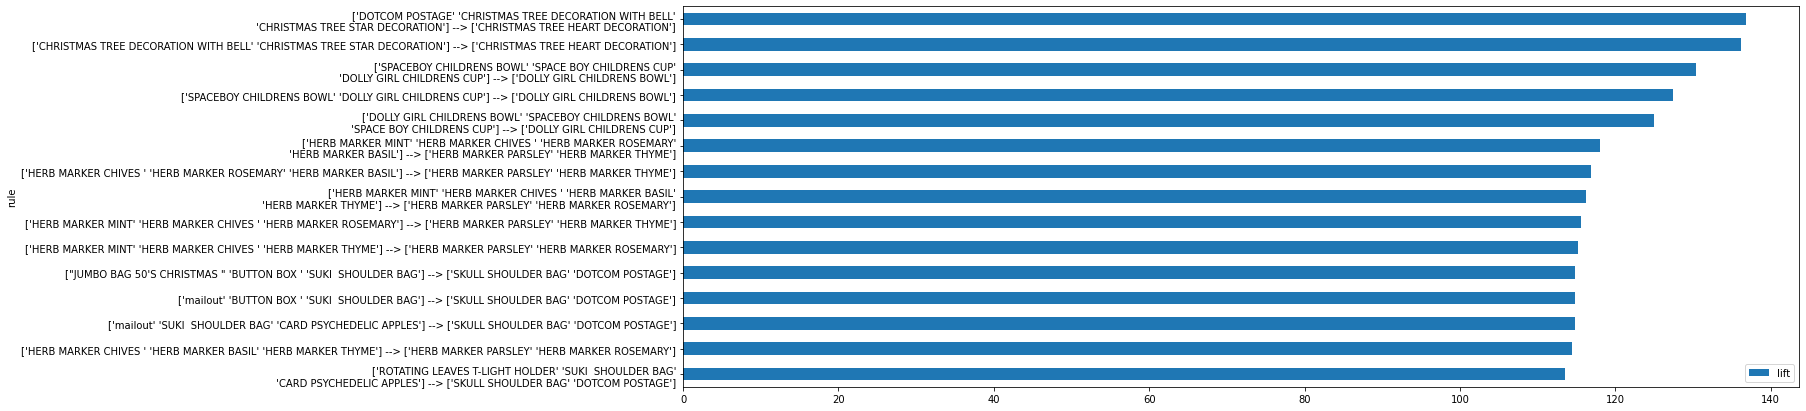

In [69]:
plot_res(data=rules_fpgrowth, left_desc_col='left_descr', right_desc_col='right_descr')    

fpgrowth gives as a bit different results (it groups several products together). We can for example see in the first row that buing a few christmas decorations usually causes buing the next one. We could recommed clients who bought [CHRISTMAS TREE DECORATION WITH BELL, DOTCOM POSTAGE, CHRISTMAS TREE STAR DECORATION] the [CHRISTMAS TREE HEART DECORATION] as they will be probably more willing to buy it. Similar results are visible for herbs products.

## FpMax

In [67]:
# find frequent sets
min_support = 0.003
frequent_itemsets = fpmax(encoded_transactions_df, min_support=min_support, use_colnames = True).sort_values(by="support")

In [70]:
frequent_itemsets.head()

,support,itemsets
0,0.003012,(23160)
2495,0.003012,"(22197, DOT, 22358)"
16832,0.003012,"(21212, 82583, 22355, 20723)"
8074,0.003012,"(23205, 22661, 23204)"
26933,0.003012,"(21931, 20728, 23201)"


In [71]:
# For the:
# association_rules(itemsets_fpmax, metric = 'confidence', min_threshold = 0.95)
# KeyError will be raised (support is not known for all itemsets)
# https://github.com/rasbt/mlxtend/issues/390
rules_fpmax = association_rules(frequent_itemsets,  support_only = True, min_threshold = 0.01).sort_values(by="lift", ascending=False)

In [73]:
# add descriptions of items found in itemsets
rules_fpmax["left_descr"] = rules_fpmax.antecedents.apply(lambda x : items_descriptions.loc[list(x)]['Description'].values)
rules_fpmax['right_descr'] = rules_fpmax.consequents.apply(lambda x : items_descriptions.loc[list(x)]['Description'].values)

In [75]:
rules_fpmax = rules_fpmax.loc[:, ['antecedents', 'consequents', 'confidence', "lift", 'left_descr', 'right_descr']]
rules_fpmax.head(3)

,antecedents,consequents,confidence,lift,left_descr,right_descr
0,(21136),(84879),NaN,NaN,[PAINTED METAL PEARS ASSORTED],[ASSORTED COLOUR BIRD ORNAMENT]
1,(84879),(21136),NaN,NaN,[ASSORTED COLOUR BIRD ORNAMENT],[PAINTED METAL PEARS ASSORTED]


For fpmax we can only use association rules based on support (because of https://github.com/rasbt/mlxtend/issues/390). However it gives some information, like the associcaiton rule indicating tht buing [PAINTED METAL PEARS ASSORTED] can cause buing [ASSORTED COLOUR BIRD ORNAMENT].

# Association rules concerning country, customer, invoice date and price data

In this section I use three associaiton rules (finding frequent itemsets) algorithms from mlxtend: apriori, fpGrowth, fpmax applied to other information than the products. I consider rules concering [customers, quarter, prices] data and [countires, quarter, prices] data separately, since combinig them all together produced many non information rules, and also there is no point in finding rules concering customers and countires together, as the fact that a given customer is from a particual country can be easily checked in the data.

## Data preparation

In [78]:
# read the data, categorize date as the quarter of the year and calculate total price for a given row
Data = pd.read_excel('./data/Online Retail.xlsx')
Data['total_price'] = Data.Quantity * Data.UnitPrice
Data['InvoiceQuarter'] = Data.InvoiceDate.apply(lambda x: (x.month-1)//3 + 1)

In [79]:
# since we want to treat invoices as transations (as previously), we group the data by invoiceNo
data_invoice = Data.groupby(by="InvoiceNo").apply(lambda x: pd.Series({
    'total_invoice_price': np.sum(x.total_price),
    'country': x.iloc[0].Country, # assume all countries on one invoice are the same
    'CustomerID': x.iloc[0].CustomerID, # assume all customers on one invoice are the same
    'Quarter': x.iloc[0].InvoiceQuarter # assume all dates on one invoice are the same
    }))

data_invoice.head()

,total_invoice_price,country,CustomerID,Quarter
InvoiceNo,,,,
536365,139.12,United Kingdom,17850.0,4
536366,22.20,United Kingdom,17850.0,4
536367,278.73,United Kingdom,13047.0,4
536368,70.05,United Kingdom,13047.0,4
536369,17.85,United Kingdom,13047.0,4


In [80]:
# remove missing values and set coherent data types
data_invoice.dropna(inplace=True)
data_invoice.CustomerID = data_invoice.CustomerID.astype("str")
data_invoice.Quarter = data_invoice.Quarter.astype("str")

In [81]:
# The data contains negative values for prices (maybe expences of the company or sth similar), so
# split data into two dataframes: one for negative prcies, and one for positive
data_invoice_pos = data_invoice[data_invoice.total_invoice_price >= 0]
data_invoice_neg = data_invoice[data_invoice.total_invoice_price < 0]

### Positive price (maybe income) preparation

<AxesSubplot:>

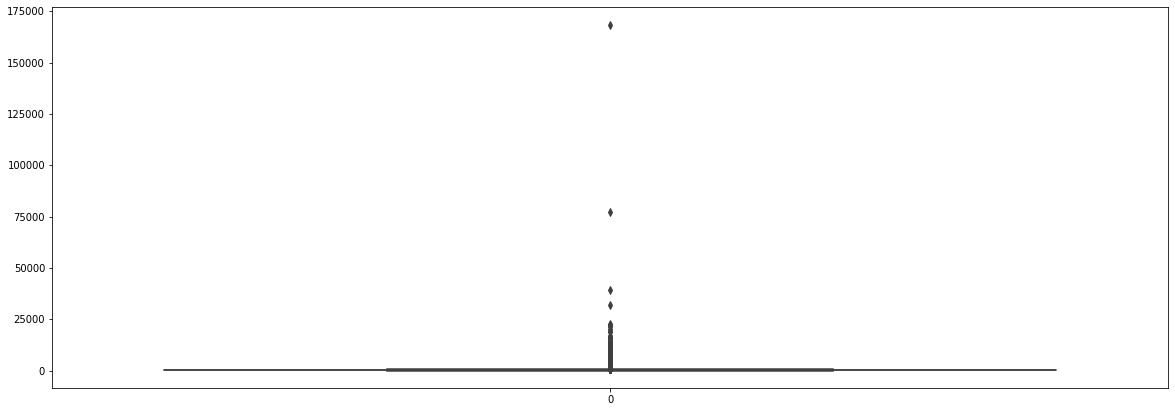

In [82]:
# we see that most prices are quite low (several hundreds), but there is also quite a large number of high prices (quite diverse, from 25k to 175k)
sns.boxplot(data=data_invoice_pos.total_invoice_price.values)

In [83]:
# I make the total price as categorical variable. The number of bins can be adjusted in many ways (equal bins width, the same number of elements in the bin etc.)
# Here however, I think the most appropiatre categorization would be to use some domain knowledge and define bins according to the 'importance' of a given transaction
# based on its price. Since I do not have this knowledge, I assume some reasonable bins
data_invoice_pos['invoice_price_cat'] = pd.cut(data_invoice_pos.total_invoice_price,  
bins = [0, 200, 400, 5000, 10000, 75000, 180000],
labels = ['very small(0 - 200)', 'small (100 - 400)', 'medium (400 - 5k)', 'large (5k - 10k)', 'very large (10k - 75k)', 'extra large (75k - 180k)'])

<AxesSubplot:xlabel='total_invoice_price', ylabel='invoice_price_cat'>

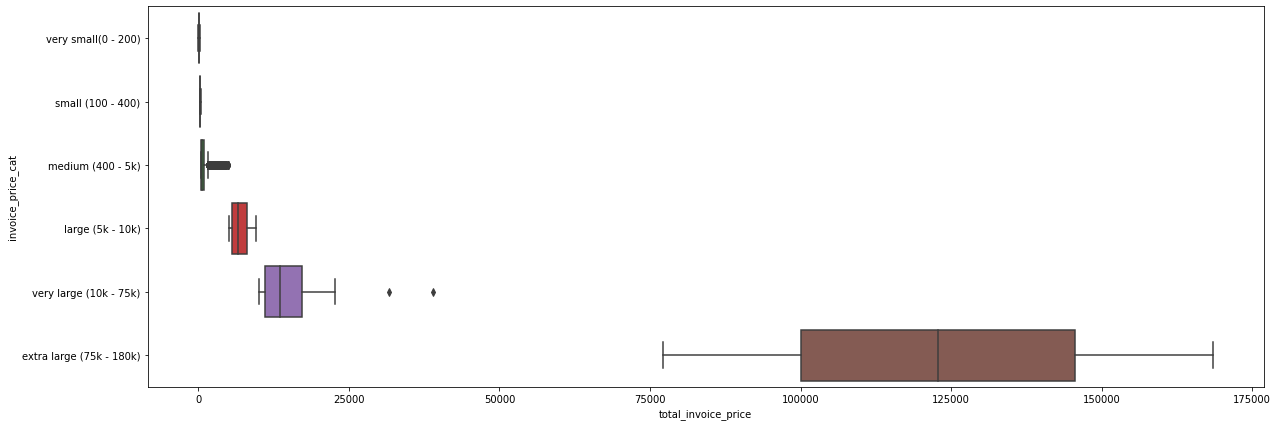

In [84]:
sns.boxplot(data=data_invoice_pos, x = 'total_invoice_price', y = 'invoice_price_cat')

In [85]:
# from above plots and values count wee see there are a lot of small price invoices and a few large ones, which is an expected result from real market data
data_invoice_pos.invoice_price_cat.value_counts()

small (100 - 400)           6475
very small(0 - 200)         6136
medium (400 - 5k)           5804
large (5k - 10k)              75
very large (10k - 75k)        40
extra large (75k - 180k)       2
Name: invoice_price_cat, dtype: int64

In [86]:
# drop continuous column with price, as the categorized one will be used
data_invoice_pos.drop(columns = ['total_invoice_price'], inplace=True)

In [87]:
# convert all data to str, needed for association rules funciton
data_invoice_pos = data_invoice_pos.astype('str')

### Negative price (maybe expences) preparation

<AxesSubplot:>

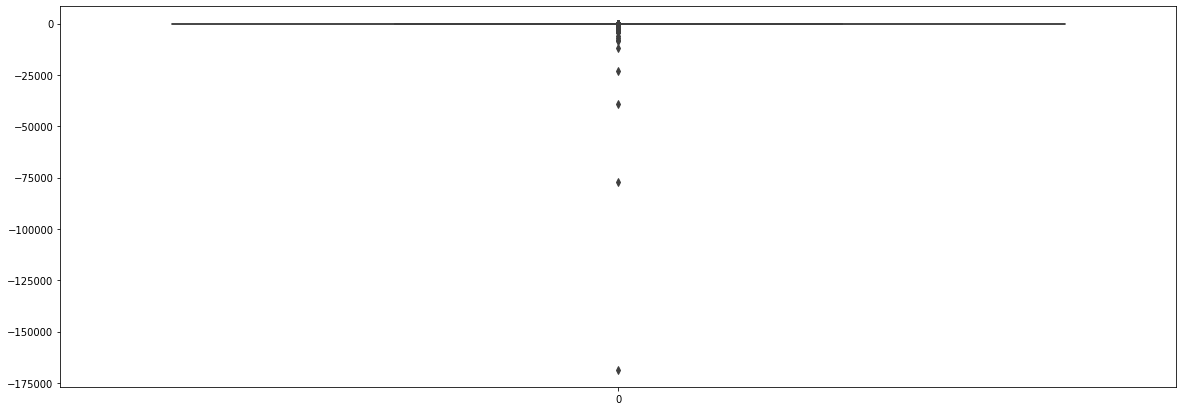

In [88]:
# again, we see that most prices are quite low (several hundreds), but there is also quite a large number of high prices (quite diverse, from -25k to -175k)
# we can perform the data preparation analogusly to positive prices
sns.boxplot(data=data_invoice_neg.total_invoice_price.values)

In [89]:
data_invoice_neg['invoice_price_cat'] = pd.cut(data_invoice_neg.total_invoice_price, 
bins = [-180000, -75000, -10000, -5000, -400, -200, 0],
labels = ['extra large (-75k - -180k)', 'very large (-10k - -75k)', 'large (-5k - -10k)', 'medium (-500 - -5k)', 'small (-200 - -400)',  'very small (0 - -200)'])

<AxesSubplot:xlabel='total_invoice_price', ylabel='invoice_price_cat'>

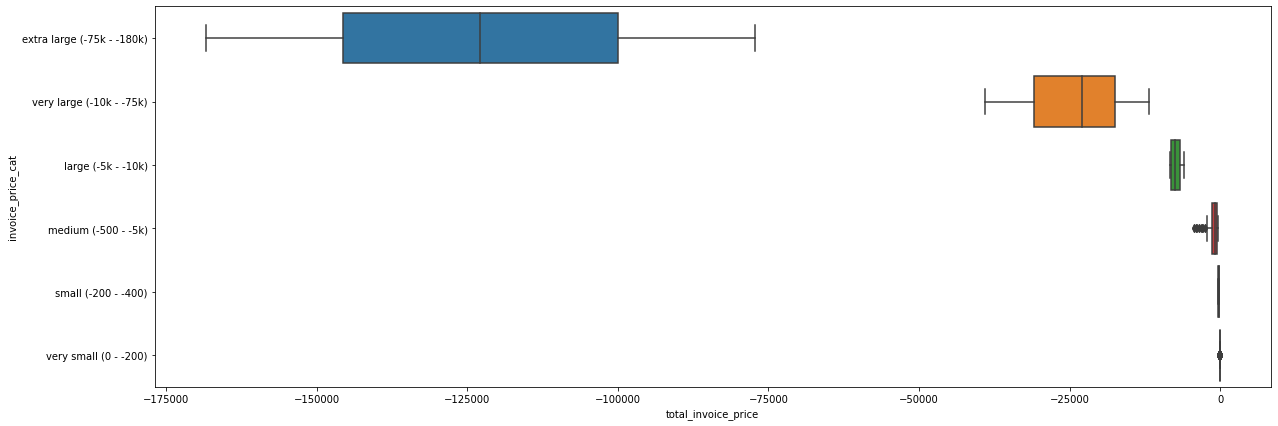

In [90]:
sns.boxplot(data=data_invoice_neg, x = 'total_invoice_price', y = 'invoice_price_cat')

In [91]:
# again, from above plots and values count wee see there are a lot of small price invoices and a few large ones, which is an expected result from real market data
data_invoice_neg.invoice_price_cat.value_counts()

very small (0 - -200)         3419
medium (-500 - -5k)            129
small (-200 - -400)             97
large (-5k - -10k)               4
very large (-10k - -75k)         3
extra large (-75k - -180k)       2
Name: invoice_price_cat, dtype: int64

In [92]:
data_invoice_neg.drop(columns = ['total_invoice_price'], inplace=True)

In [93]:
data_invoice_neg = data_invoice_neg.astype('str')

## Function to perform finding frequent itemsets and association rules

For this dataset, reasonable values of min_support tourned out to be 0.003 and for confidence while finding associaiton rules - 0.6. They give enough number of reasonable associaion rules.

In [94]:
def get_frequent_sets_and_rules(dat, columns):
    dat = dat.loc[:, columns].values.tolist()
    T = TransactionEncoder()
    dat = T.fit_transform(dat)
    dat = pd.DataFrame(dat, columns = T.columns_)

    itemsets_apriori = apriori(dat, min_support=0.003, use_colnames=True)
    itemsets_fpgrowth = fpgrowth(dat, min_support=0.003, use_colnames=True)
    itemsets_fpmax = fpmax(dat, min_support=0.003, use_colnames=True)

    rules_apriori = association_rules(itemsets_apriori, metric = 'confidence', min_threshold = 0.6).sort_values(by="lift", ascending=False)
    rules_fpgrowth = association_rules(itemsets_fpgrowth, metric = 'confidence', min_threshold = 0.6).sort_values(by="lift", ascending=False)
    # For the:
    # association_rules(itemsets_fpmax, metric = 'confidence', min_threshold = 0.95)
    # KeyError will be raised (support is not known for all itemsets)
    # https://github.com/rasbt/mlxtend/issues/390
    rules_fpmax = association_rules(itemsets_fpmax,  support_only = True, min_threshold = 0.01).sort_values(by="lift", ascending=False)

    return itemsets_apriori.sort_values(by="support", ascending=False), \
        itemsets_fpgrowth.sort_values(by="support", ascending=False), \
        itemsets_fpmax.sort_values(by="support", ascending=False), \
        rules_apriori, \
        rules_fpgrowth, \
        rules_fpmax
    

## Association rules for customers, quarter and prices data

### Positive prices 

In [95]:
itemsets_apriori, \
itemsets_fpgrowth, \
itemsets_fpmax, \
rules_apriori, \
rules_fpgrowth, \
rules_fpmax \
     = get_frequent_sets_and_rules(data_invoice_pos, ["CustomerID", "invoice_price_cat", "Quarter"])

In [96]:
itemsets_apriori.head()

,support,itemsets
15,0.364965,(4)
18,0.349320,(small (100 - 400))
19,0.331032,(very small(0 - 200))
17,0.313120,(medium (400 - 5k))
14,0.235650,(3)


In [97]:
itemsets_fpgrowth.head()

,support,itemsets
0,0.364965,(4)
2,0.349320,(small (100 - 400))
1,0.331032,(very small(0 - 200))
3,0.313120,(medium (400 - 5k))
19,0.235650,(3)


In [98]:
itemsets_fpmax.head()

,support,itemsets
25,0.128992,"(small (100 - 400), 4)"
24,0.112592,"(4, medium (400 - 5k))"
23,0.080438,"(3, medium (400 - 5k))"
22,0.080006,"(small (100 - 400), 3)"
20,0.077525,"(small (100 - 400), 2)"


In [99]:
rules_apriori.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(14606.0),(very small(0 - 200)),0.005017,0.331032,0.004478,0.892473,2.696037,0.002817,6.221407
1,(12971.0),(very small(0 - 200)),0.004640,0.331032,0.003992,0.860465,2.599345,0.002456,4.794274
0,(12748.0),(very small(0 - 200)),0.011329,0.331032,0.008578,0.757143,2.287223,0.004828,2.754576


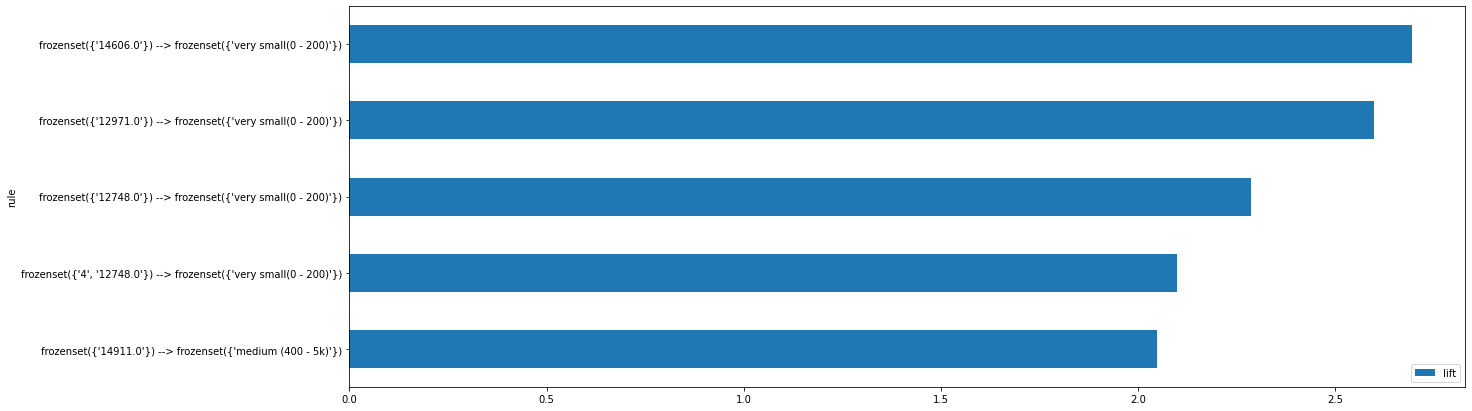

In [100]:
plot_res(rules_apriori)

In [101]:
rules_fpgrowth.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(14606.0),(very small(0 - 200)),0.005017,0.331032,0.004478,0.892473,2.696037,0.002817,6.221407
4,(12971.0),(very small(0 - 200)),0.004640,0.331032,0.003992,0.860465,2.599345,0.002456,4.794274
0,(12748.0),(very small(0 - 200)),0.011329,0.331032,0.008578,0.757143,2.287223,0.004828,2.754576


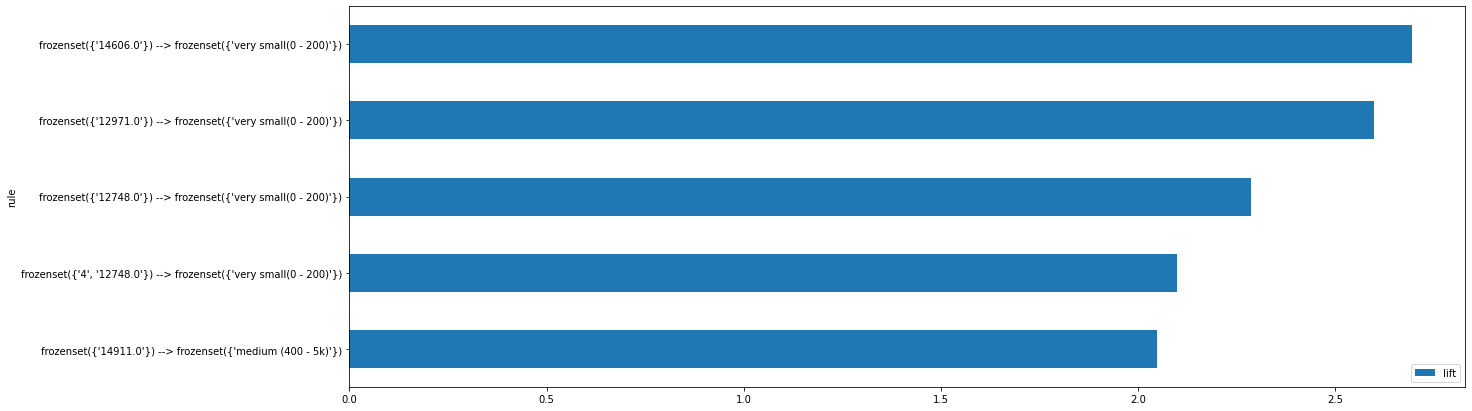

In [102]:
plot_res(rules_fpgrowth)

In [103]:
rules_fpmax.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(medium (400 - 5k)),NaN,NaN,0.054866,NaN,NaN,NaN,NaN
1,(medium (400 - 5k)),(1),NaN,NaN,0.054866,NaN,NaN,NaN,NaN
2,(1),(very small(0 - 200)),NaN,NaN,0.059506,NaN,NaN,NaN,NaN


From above outputs we can find out that it is likely that customer (14606.0) will buy product for <= 200 price and (14911.0) for 400-5k. The most frequent consequence is the price: (very small(0 - 200)), as it occurs most often in the data.

### Negative price

In [104]:
itemsets_apriori, \
itemsets_fpgrowth, \
itemsets_fpmax, \
rules_apriori, \
rules_fpgrowth, \
rules_fpmax \
     = get_frequent_sets_and_rules(data_invoice_neg, ["CustomerID", "invoice_price_cat", "Quarter"])

In [105]:
itemsets_apriori.head()

,support,itemsets
38,0.935687,(very small (0 - -200))
35,0.331965,(4)
85,0.308429,"(4, very small (0 - -200))"
34,0.231801,(3)
33,0.230706,(2)


In [106]:
itemsets_fpgrowth.head()

,support,itemsets
0,0.935687,(very small (0 - -200))
1,0.331965,(4)
39,0.308429,"(4, very small (0 - -200))"
37,0.231801,(3)
36,0.230706,(2)


In [107]:
itemsets_fpmax.head()

,support,itemsets
42,0.013410,"(4, medium (-500 - -5k))"
41,0.009852,"(medium (-500 - -5k), 3)"
38,0.009031,"(4, small (-200 - -400))"
28,0.008484,"(very small (0 - -200), 14527.0)"
40,0.006842,"(2, medium (-500 - -5k))"


In [108]:
rules_apriori.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(14096.0),(medium (-500 - -5k)),0.004652,0.035304,0.003010,0.647059,18.328317,0.002846,2.733306
38,"(17841.0, 4)",(very small (0 - -200)),0.003558,0.935687,0.003558,1.000000,1.068734,0.000229,inf
26,(17677.0),(very small (0 - -200)),0.003558,0.935687,0.003558,1.000000,1.068734,0.000229,inf


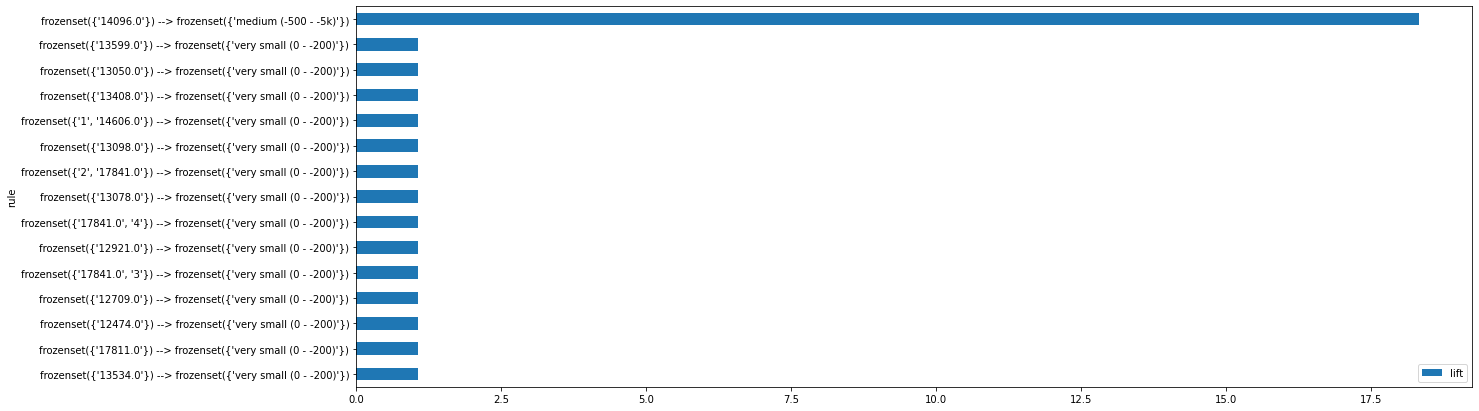

In [109]:
plot_res(rules_apriori)

In [110]:
rules_fpgrowth.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(14096.0),(medium (-500 - -5k)),0.004652,0.035304,0.003010,0.647059,18.328317,0.002846,2.733306
16,(13599.0),(very small (0 - -200)),0.003284,0.935687,0.003284,1.000000,1.068734,0.000211,inf
35,(14194.0),(very small (0 - -200)),0.003010,0.935687,0.003010,1.000000,1.068734,0.000194,inf


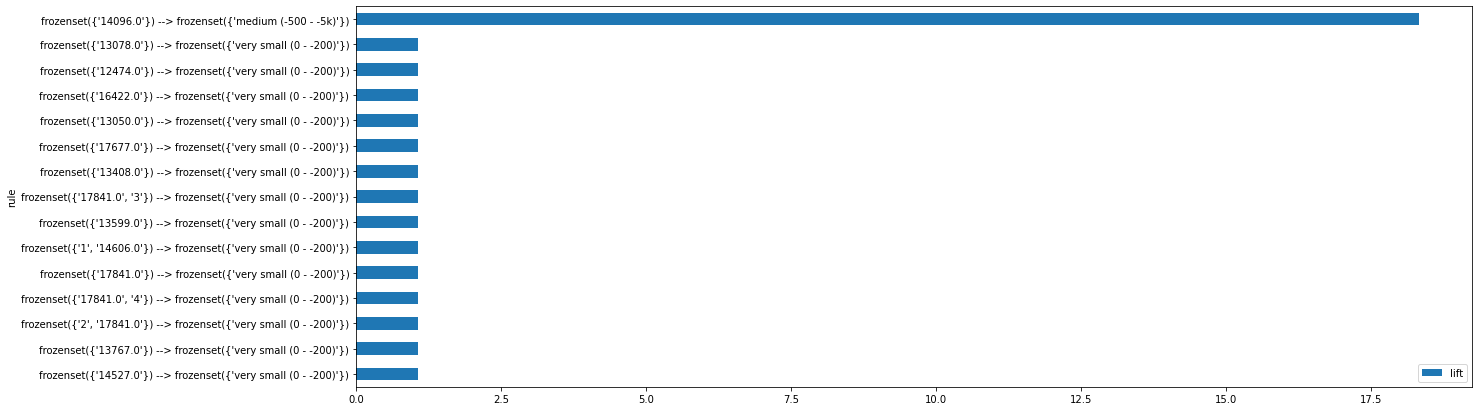

In [111]:
plot_res(rules_fpgrowth)

In [112]:
rules_fpmax.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(4),(medium (-500 - -5k)),NaN,NaN,0.01341,NaN,NaN,NaN,NaN
1,(medium (-500 - -5k)),(4),NaN,NaN,0.01341,NaN,NaN,NaN,NaN


For negative price data, we can get analogous conclusions as in the case of positive price data. In both cases, the quarter of the year does not seem to play an important role.

## Asociation rules for Countires, dates and Prices data

### Positive prices data

In [113]:
itemsets_apriori, \
itemsets_fpgrowth, \
itemsets_fpmax, \
rules_apriori, \
rules_fpgrowth, \
rules_fpmax \
     = get_frequent_sets_and_rules(data_invoice_pos, ["country", "invoice_price_cat", "Quarter"])

In [114]:
itemsets_apriori.head()

,support,itemsets
12,0.898198,(United Kingdom)
3,0.364965,(4)
15,0.349320,(small (100 - 400))
16,0.331032,(very small(0 - 200))
39,0.328496,"(4, United Kingdom)"


In [115]:
itemsets_fpgrowth.head()

,support,itemsets
0,0.898198,(United Kingdom)
1,0.364965,(4)
3,0.349320,(small (100 - 400))
2,0.331032,(very small(0 - 200))
17,0.328496,"(4, United Kingdom)"


In [116]:
itemsets_fpmax.head()

,support,itemsets
31,0.119335,"(small (100 - 400), 4, United Kingdom)"
30,0.112646,"(4, United Kingdom, very small(0 - 200))"
29,0.094681,"(4, United Kingdom, medium (400 - 5k))"
27,0.073802,"(small (100 - 400), 3, United Kingdom)"
24,0.073101,"(2, United Kingdom, very small(0 - 200))"


In [117]:
rules_apriori.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,"(4, EIRE)",(medium (400 - 5k)),0.005071,0.313120,0.003453,0.680851,2.174406,0.001865,2.152223
4,(EIRE),(medium (400 - 5k)),0.014027,0.313120,0.009441,0.673077,2.149579,0.005049,2.101043
13,"(2, very small(0 - 200))",(United Kingdom),0.077039,0.898198,0.073101,0.948880,1.056426,0.003904,1.991412


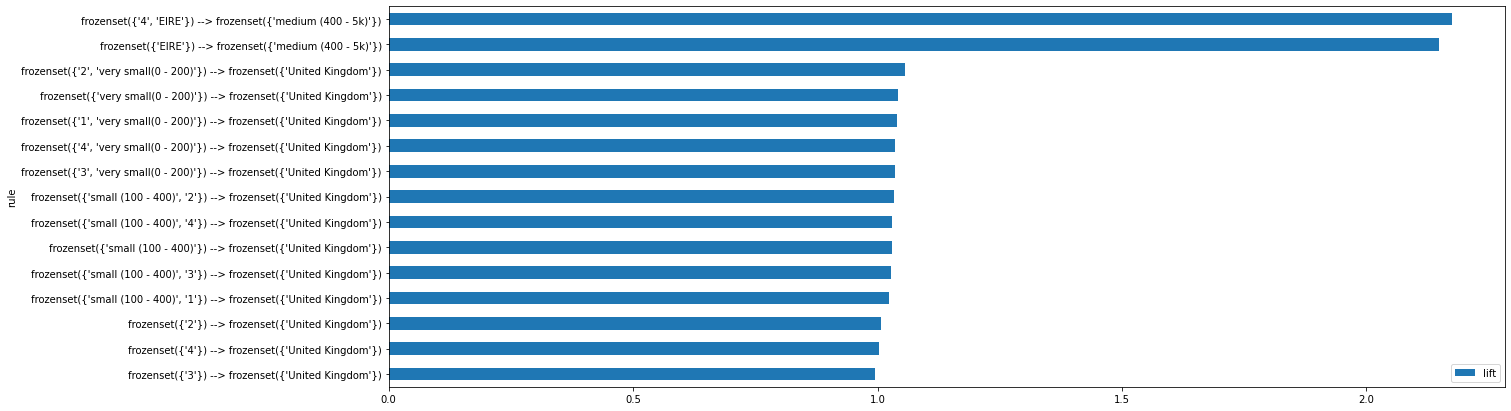

In [118]:
plot_res(rules_apriori)

In [119]:
rules_fpgrowth.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,"(4, EIRE)",(medium (400 - 5k)),0.005071,0.313120,0.003453,0.680851,2.174406,0.001865,2.152223
7,(EIRE),(medium (400 - 5k)),0.014027,0.313120,0.009441,0.673077,2.149579,0.005049,2.101043
15,"(2, very small(0 - 200))",(United Kingdom),0.077039,0.898198,0.073101,0.948880,1.056426,0.003904,1.991412


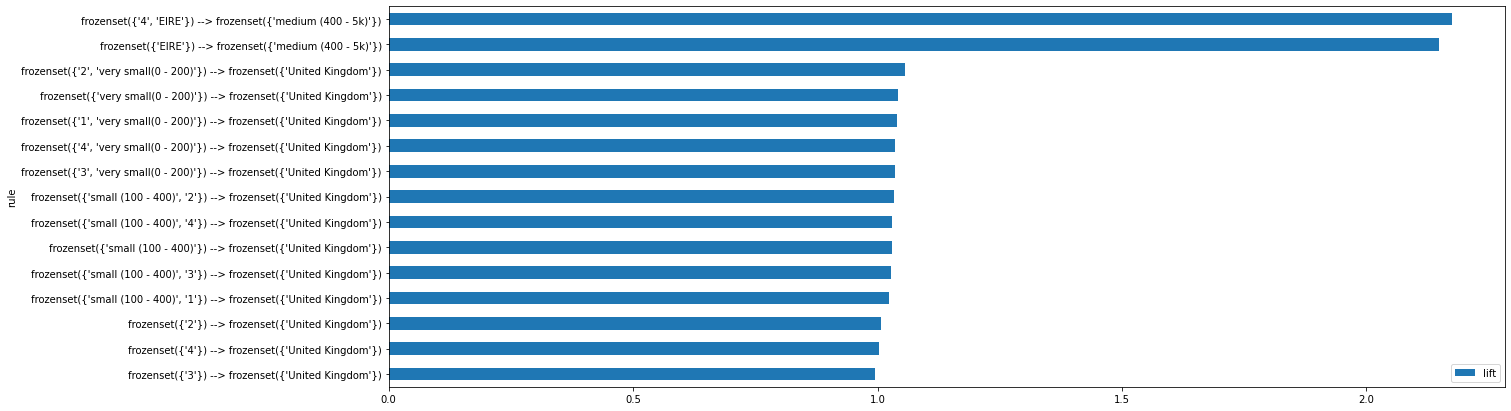

In [120]:
plot_res(rules_fpgrowth)

In [121]:
rules_fpmax.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(1, United Kingdom)",(medium (400 - 5k)),NaN,NaN,0.045155,NaN,NaN,NaN,NaN
1,"(1, medium (400 - 5k))",(United Kingdom),NaN,NaN,0.045155,NaN,NaN,NaN,NaN
2,"(United Kingdom, medium (400 - 5k))",(1),NaN,NaN,0.045155,NaN,NaN,NaN,NaN


Above outcomes allow to conclude that if we have a customer from EIRE country doing the shopping in 4th quarter, they will spend the medium amount of money. We also have the similar rule but without the quarter data. Because most of the customers are from UK, it appears often in the rules. 

### Negative prices data

In [122]:
itemsets_apriori, \
itemsets_fpgrowth, \
itemsets_fpmax, \
rules_apriori, \
rules_fpgrowth, \
rules_fpmax \
     = get_frequent_sets_and_rules(data_invoice_neg, ["country", "invoice_price_cat", "Quarter"])

In [123]:
itemsets_apriori.head()

,support,itemsets
16,0.935687,(very small (0 - -200))
13,0.877942,(United Kingdom)
53,0.826492,"(very small (0 - -200), United Kingdom)"
3,0.331965,(4)
43,0.308429,"(4, very small (0 - -200))"


In [124]:
itemsets_fpgrowth.head()

,support,itemsets
0,0.935687,(very small (0 - -200))
1,0.877942,(United Kingdom)
17,0.826492,"(very small (0 - -200), United Kingdom)"
2,0.331965,(4)
18,0.308429,"(4, very small (0 - -200))"


In [125]:
itemsets_fpmax.head()

,support,itemsets
27,0.269841,"(4, very small (0 - -200), United Kingdom)"
25,0.195950,"(2, very small (0 - -200), United Kingdom)"
26,0.188560,"(very small (0 - -200), 3, United Kingdom)"
24,0.172140,"(1, very small (0 - -200), United Kingdom)"
23,0.013410,"(4, Germany, very small (0 - -200))"


In [126]:
rules_apriori.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36,"(Switzerland, 3)",(very small (0 - -200)),0.003010,0.935687,0.003010,1.0,1.068734,0.000194,inf
20,"(1, Germany)",(very small (0 - -200)),0.008484,0.935687,0.008484,1.0,1.068734,0.000546,inf
19,"(1, France)",(very small (0 - -200)),0.005200,0.935687,0.005200,1.0,1.068734,0.000334,inf


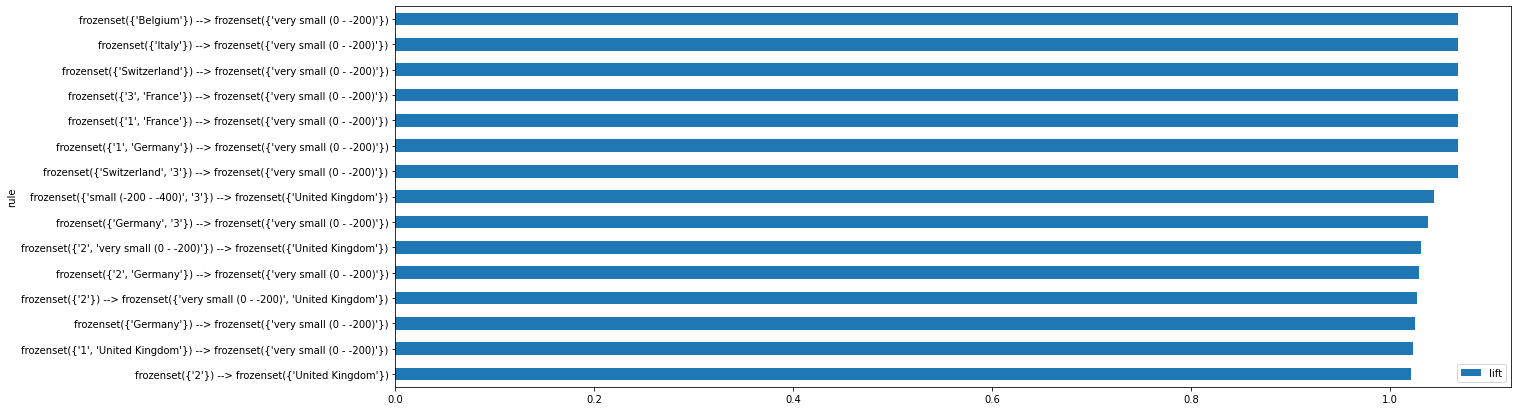

In [127]:
plot_res(rules_apriori)

In [128]:
rules_fpgrowth.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
25,(Italy),(very small (0 - -200)),0.004652,0.935687,0.004652,1.0,1.068734,0.000299,inf
28,"(1, France)",(very small (0 - -200)),0.005200,0.935687,0.005200,1.0,1.068734,0.000334,inf
30,"(3, France)",(very small (0 - -200)),0.003010,0.935687,0.003010,1.0,1.068734,0.000194,inf


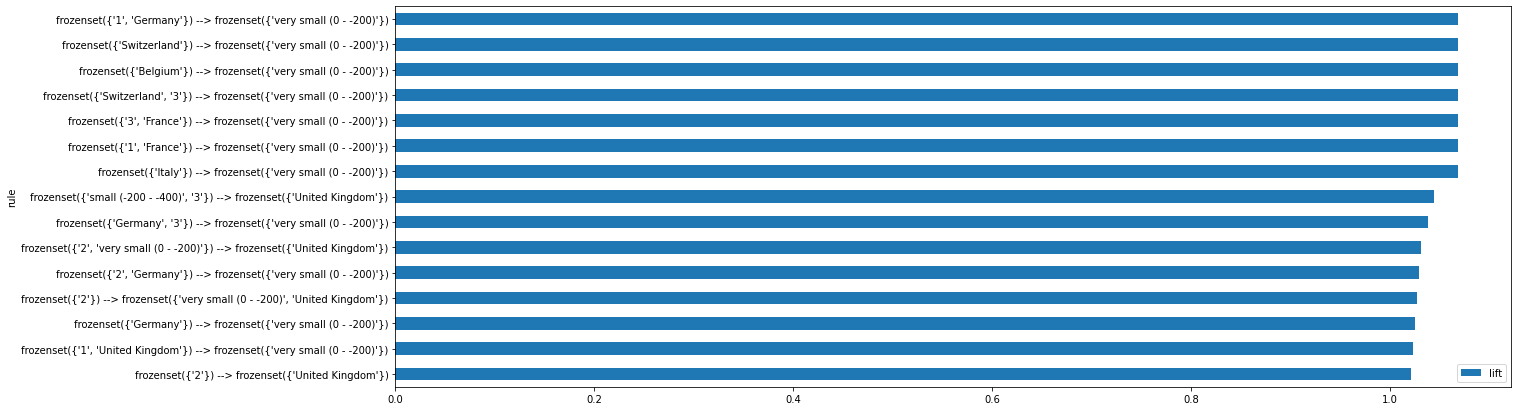

In [136]:
plot_res(rules_fpgrowth)

In [137]:
rules_fpmax.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(medium (-500 - -5k), 4)",(United Kingdom),NaN,NaN,0.011221,NaN,NaN,NaN,NaN
1,"(medium (-500 - -5k), United Kingdom)",(4),NaN,NaN,0.011221,NaN,NaN,NaN,NaN
2,"(4, United Kingdom)",(medium (-500 - -5k)),NaN,NaN,0.011221,NaN,NaN,NaN,NaN


For negative prices data, the conclusions are anlogous to the positive one.

## Summary

In my opinion, the most interesting results can be obtained with association rules applied to products. They can be used as the recommendation system to imporove the number of sold items and as a resutlt the income of the company. 

In regards to different algorithms for finding frequent itemsets: apripori and fpgrowth gave the same itemsets and the fpmax itemssets ususally differed a bit. The association rules found for apriori and fpgrowth itemssets are more interesting, since for fpmax we had to realy only on the support (implenentain issue). I also used two different implementation of apriori and find the one from mlxtend better (easier to use and perforemd a bit faster). 